In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import NaiveBayes

In [3]:
df = pd.read_csv('dataset/adult.data', na_values=[' ?'])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,high-income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [4]:
variables_names = df.columns.values
target_variable = variables_names[-1]
feature_variables = variables_names[:-1]

## Checking for NA values

### Removing redundant or useless features

In [10]:
np.sum(pd.isnull(df),0)

age                   0
 workclass         1836
 fnlwgt               0
 education            0
 education-num        0
 marital-status       0
 occupation        1843
 relationship         0
 race                 0
 sex                  0
 capital-gain         0
 capital-loss         0
 hours-per-week       0
 native-country     583
 high-income          0
dtype: int64

We can drop NA values, since they are only a few, w.r.t. the size of the dataset.

In [13]:
df = df.dropna()

In [5]:
useless_features = ['fnlwgt', 'education-num']
# df.drop(useless_features, axis=1, inplace=True)
# variables_names.remove(feature)

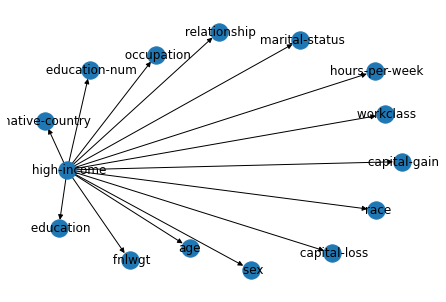

In [6]:
nb_model = NaiveBayes(
    feature_vars=feature_variables,
    dependent_var=target_variable
)
nx.draw(nb_model, with_labels=True)
plt.show()

### Train/test split

In [17]:
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
test = df[~mask]
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

Training set shape: (24128, 15)
Test set shape: (6034, 15)


### Naive Bayes model

In [7]:
nb_model.fit(df)
nb_model.get_cpds()

[<TabularCPD representing P( capital-gain:119 |  high-income:2) at 0x1417e8d30>,
 <TabularCPD representing P( capital-loss:92 |  high-income:2) at 0x1419eac10>,
 <TabularCPD representing P( education:16 |  high-income:2) at 0x1419eaf10>,
 <TabularCPD representing P( education-num:16 |  high-income:2) at 0x1419ea2b0>,
 <TabularCPD representing P( fnlwgt:21648 |  high-income:2) at 0x1419eaf70>,
 <TabularCPD representing P( high-income:2) at 0x1419ea910>,
 <TabularCPD representing P( hours-per-week:94 |  high-income:2) at 0x1419eafd0>,
 <TabularCPD representing P( marital-status:7 |  high-income:2) at 0x141e868e0>,
 <TabularCPD representing P( native-country:41 |  high-income:2) at 0x141e86ac0>,
 <TabularCPD representing P( occupation:14 |  high-income:2) at 0x141e86cd0>,
 <TabularCPD representing P( race:5 |  high-income:2) at 0x141e86d60>,
 <TabularCPD representing P( relationship:6 |  high-income:2) at 0x141e86910>,
 <TabularCPD representing P( sex:2 |  high-income:2) at 0x141e86af0>,


### Estimate CPTs from data